<a href="https://colab.research.google.com/github/58191554/PointNet-Project/blob/main/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PointNet
This is a homework based on the paper [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593)

This homework refers to the article [Deep Learning on Point clouds](https://towardsdatascience.com/deep-learning-on-point-clouds-implementing-pointnet-in-google-colab-1fd65cd3a263)

## Preparing the point cloud data

In [ ]:
import math
import random
import os
import numpy as np
np.random.seed(7)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


import plotly.graph_objects as go
import plotly.express as px

In [ ]:
!pwd

/content


In [ ]:
!pip install path.py;
from path import Path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download the dataset

When you download a file using **wget** in Google Colab, the file is saved to the virtual machine's temporary storage associated with the current runtime session. By default, the downloaded file will be saved in the current working directory, which is /content.

The downloaded file will be lost when the runtime is disconnected.

In [ ]:
#@title Download the dataset
%cd /content
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
!unzip -q ModelNet10.zip;

/content
--2023-05-03 02:19:52--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-05-03 02:19:53--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  13.5MB/s    in 37s     

2023-05-03 02:20:30 (12.3 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



The dataset contains 10 classes, labeled from 0, 1, ..., 9

In [ ]:
path_unsampled = Path("ModelNet10")
# read all the directories in ModelNet10
folders = [dir for dir in sorted(os.listdir(path_unsampled)) if os.path.isdir(path_unsampled/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

### Understand the data

This dataset consists of **.off** files that contain meshes represented by **vertices** and **triangular faces**

Take the data in the file 'chair/train/chair_0001.off' as an example:

- The first line is a symbol **OFF** representing the file is an .off file.
- The second line has three numbers. The first number is the number of vertices which is 2382 and the second number is the number of faces which is 2234.
- The following 2382 lines are coordinates of vertices in the space.
- The last 2234 lines are faces in the space. In each line, the first number is 3, the following 3 numbers are three vertices of a triangle.

In [ ]:
#@title display the first 6 lines in the file
file_path = path_unsampled/"chair/train/chair_0001.off"
!sed -n '1,6p' "$file_path" | cat

OFF
2382 2234 0
-9.699500 0.066250 -1.575088
-9.696500 -8.837050 -18.008024
-9.699500 -9.052550 -17.887559
-9.694500 -8.621550 -18.128488


In [ ]:
#@title display the first line 3000-3005 in the file
!sed -n '3000,3005p' "$file_path" | cat

3 571 572 573
3 572 574 573
3 573 574 575
3 574 576 575
3 575 576 577
3 576 578 577


### Read the data

In [ ]:
def read_off(file):
  '''
  return: verts: List[List]
          faces: List[List]
  '''
  if 'OFF' != file.readline().strip():
    raise('Not a valid OFF header')
  # read the first line
  n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
  # read vertices and facess
  verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
  faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
  return verts, faces

def read_sampled_off(file):
  if 'OFF' != file.readline().strip():
    raise('Not a valid OFF header')
  file.readline()
  file.readline()
  n_points = tuple([int(s) for s in file.readline().strip().split(' ')])[0]
  file.readline()
  points = [[float(s) for s in file.readline().strip().split(' ')] for i in range(n_points)]
  return points

In [ ]:
# read vertices and faces of file chair_0001.off
with open(path_unsampled/"chair/train/chair_0001.off", 'r') as f:
  verts, faces = read_off(f)

### Visualize the *data*

In [ ]:
def visualize_rotate(data):
  x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
  frames=[]

  def rotate_z(x, y, z, theta):
    w = x+1j*y
    return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

  for t in np.arange(0, 10.26, 0.1):
    xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
    frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
  fig = go.Figure(data=data,
                  layout=go.Layout(updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                            method='animate',
                                            args=[None, dict(frame=dict(duration=50, redraw=True),
                                                            transition=dict(duration=0),
                                                            fromcurrent=True,
                                                            mode='immediate')]
                                                  )
                                            ]
                                      )
                                  ]
                                  ),
                  frames=frames)
  return fig

In [ ]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

In [ ]:
#@title visualize vertices in 3d space
x,y,z = np.array(verts).T
pcshow(x,y,z)

### Transform the data into real point cloud

As you can see in the visualization, the point cloud for vertices does not really look like a chair. 

This is because we haven't utilized faces information yet. Remember, we want the point cloud for an object to be evenly distributed among the faces of the object.

In the following PointCloudData class, we will do the following: 
- Sample points from faces of each object
- Normalize the data
- Add rotation to the pointcloud
- Add random gaussian noise to the point cloud

In [ ]:
# The class that handles reading data
class PointCloudData(Dataset):
    def __init__(self, root_dir, folder="train", sampled=False, k=1024, norm=True, rotation=True, noise=True):
      self.root_dir = root_dir
      self.sampled = sampled
      self.k = k
      folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
      self.classes = {folder: i for i, folder in enumerate(folders)}
      self.files = []
      self.norm = norm
      self.rotation = rotation
      self.noise = noise
      for directory in self.classes.keys():
        new_dir = root_dir/Path(directory)/folder
        for file in os.listdir(new_dir):
          if file.endswith('.off'):
            data = {}
            data['path'] = new_dir/file
            data['category'] = directory
            self.files.append(data)

    def __len__(self):
      return len(self.files)
    
    def sample(self, verts, faces):
      ########################################################################
      # TODO: sample k points among all faces with weights by their areas
      # i.e., we want larger triangles to have more points to be sampled in 
      # the plane of triangle with larger area. The sampled points in each face 
      # should be proportional to its area
      # Input: self.k: number of samples
      #        verts: List[List] contains all vertices of an object
      #        faces: List[List] contains the indices of vertices of each triangle
      # Return: numpy array of shape [k, 3]
      # hint: 1. read the following two functions: triangle_area and sample_point
      #       2. random.choices can be helpful
      ########################################################################
      areas = np.zeros((len(faces)))
      verts = np.array(verts)
      for i in range(len(areas)):
        areas[i] = self.triangle_area(verts[faces[i][0]], verts[faces[i][1]], verts[faces[i][2]])
      # sample k points among all faces with weights by their areas
      sampled_faces = random.choices(faces, weights=areas, k=self.k)
      pointcloud = np.zeros((self.k, 3))
      for i in range(len(sampled_faces)):
        pointcloud[i] = self.sample_point(verts[sampled_faces[i][0]],
                                          verts[sampled_faces[i][1]],
                                          verts[sampled_faces[i][2]])
      return pointcloud
      ########################################################################

    def triangle_area(self, pt1, pt2, pt3):
      '''
      input: Coordinates of three vertices of a triangle
      output: The area of the triangle
      '''
      side_a = np.linalg.norm(pt1 - pt2)
      side_b = np.linalg.norm(pt2 - pt3)
      side_c = np.linalg.norm(pt3 - pt1)
      s = 0.5 * (side_a + side_b + side_c)
      return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5 


    def sample_point(self, pt1, pt2, pt3):
      '''
      input: Coordinates of three vertices of a triangle
      output: The coordinate of a randomly sampled point in the triangle
      '''
      s, t = sorted([np.random.random(), np.random.random()])
      f = lambda i: s * pt1[i] + (t-s) * pt2[i] + (1-t) * pt3[i]
      return [f(0), f(1), f(2)]

    def __getitem__(self, idx):
      path = self.files[idx]['path']
      # print(path)
      category = self.files[idx]['category']

      if self.sampled:
        with open(path, 'r') as f:
          pointcloud = np.array(read_sampled_off(f)) 
      else:
        with open(path, 'r') as f:
          verts, faces = read_off(f)
          pointcloud = self.sample(verts, faces)

      if self.normalize:
        pointcloud = self.normalize(pointcloud)
      if self.rotation:
        pointcloud = self.rotate(pointcloud)
      if self.noise:
        pointcloud = self.add_noise(pointcloud)
      

      return {'pointcloud': torch.from_numpy(pointcloud), 
              'category': self.classes[category]}

    def normalize(self, pointcloud):
      ########################################################################
      # TODO: Given an unnormalized pointcloud, return the normalized pointclud.
      # we want the normalized_pointcloud to have the following property:
      # 1. The mean of all points in pointcloud is (0,0,0)
      # 2. All the point in the pointcloud are in the unit sphere with center (0,0,0)
      # 
      # Input: pointcloud: numpy array of shape [k, 3] where k is 
      #        the number of sampled points of the pointcloud
      # Return: norm_pointcloud: numpy array of shape [K, 3] which is normalized
      ########################################################################
      pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
      norm_pointcloud = pointcloud / np.max(np.linalg.norm(pointcloud, axis=1))
      ########################################################################
      return norm_pointcloud

    def rotate(self, pointcloud):
      theta = random.random() * 2. * math.pi # rotation angle
      rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                          [ math.sin(theta),  math.cos(theta),    0],
                          [0,                             0,      1]])

      pointcloud = rot_matrix.dot(pointcloud.T).T
      return pointcloud

    def add_noise(self, pointcloud):
      noise = np.random.normal(0, 0.02, (pointcloud.shape))
      noisy_pointcloud = pointcloud + noise
      return noisy_pointcloud

    

Test your implementation

The sampling result should look like this: 

<img src="https://github.com/58191554/PointNet-Project/blob/main/img/desk_points.png?raw=true" alt="chair" width="300" height="200">

In [ ]:
# Testing your sample function, please visualize your sampled data
train_dataset_grade = PointCloudData(path_unsampled, folder='train', sampled=False, k=3000, 
                               norm=False, rotation=False, noise=False)
with open(path_unsampled/"chair/train/chair_0001.off", 'r') as f:
  verts, faces = read_off(f)
pointcloud_grade = train_dataset_grade.sample(verts, faces)
pcshow(*pointcloud_grade.T)

In [ ]:
# Testing normalize
torch.manual_seed(89)
correct1 = np.array([[-0.65969586, -0.61102563, -0.4375487],
                     [-0.17281342,  0.41985238,  0.22575168],
                     [ 0.57366514,  0.21148148, -0.09146313],
                     [-0.21824756, -0.01621679,  0.14690676],
                     [ 0.55209243,  0.02533382, -0.38807073],
                     [-0.07500052, -0.02942534,  0.5444241 ]])
pointcloud = torch.randn(6,3).numpy()
res1 = train_dataset_grade.normalize(pointcloud)
print('Testing normalize:')
if not np.allclose(res1, correct1, rtol=1e-03):
  print("Error")
  print("Your answer is: ", res1)
  print("The expected answer is: ", correct1)
else:
  print('passed')


Testing normalize:
passed


In [ ]:
#@title read the data and visualize the data
train_dataset_visualize = PointCloudData(path_unsampled, folder='train', sampled=False, k=3000, 
                               norm=True, rotation=True, noise=False)
test_dataset_visualize = PointCloudData(path_unsampled, folder='test', sampled=False, k=3000, 
                              norm=True, rotation=False, noise=False)

In [ ]:
inv_classes = {i: cat for cat, i in train_dataset_visualize.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [ ]:
print('Train dataset size: ', len(train_dataset_visualize))
print('Test dataset size: ', len(test_dataset_visualize))
print('Number of classes: ', len(train_dataset_visualize.classes))
print('Sample pointcloud shape: ', train_dataset_visualize[0]['pointcloud'].size())
print('Sample pointcloud dtype: ', train_dataset_visualize[0]['pointcloud'].dtype)
print('Class: ', inv_classes[train_dataset_visualize[0]['category']])

Train dataset size:  3991
Test dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([3000, 3])
Sample pointcloud dtype:  torch.float64
Class:  bathtub


In [ ]:
item_visualize = train_dataset_visualize[820] # feel free to change the index to visualize different pointcloud
pointcloud = item_visualize['pointcloud']
category = item_visualize['category']
print('Class:', inv_classes[category])
pcshow(*pointcloud.T)

Class: chair


### Download the pre-sampled data

During training, since sampling data from faces takes a lot of time. To save time, we have pre-sampled the data for you. We sampled 1024 points in each pointcloud as in the paper. Now we download the pre-sampled data.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nt-KtkxvpfJVwBZL51uEnwG_khK67M6u' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1nt-KtkxvpfJVwBZL51uEnwG_khK67M6u" -O pre_sample.zip && rm -rf /tmp/cookies.txt
!unzip -q pre_sample.zip;

--2023-05-03 02:20:51--  https://docs.google.com/uc?export=download&confirm=t&id=1nt-KtkxvpfJVwBZL51uEnwG_khK67M6u
Resolving docs.google.com (docs.google.com)... 74.125.24.139, 74.125.24.113, 74.125.24.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.24.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-4s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3q12k9i6e23luk6tuvde3jeovtrd487r/1683080400000/12144501948969093587/*/1nt-KtkxvpfJVwBZL51uEnwG_khK67M6u?e=download&uuid=5789f427-99a1-4ee7-bf73-90aec373bf29 [following]
--2023-05-03 02:20:52--  https://doc-10-4s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3q12k9i6e23luk6tuvde3jeovtrd487r/1683080400000/12144501948969093587/*/1nt-KtkxvpfJVwBZL51uEnwG_khK67M6u?e=download&uuid=5789f427-99a1-4ee7-bf73-90aec373bf29
Resolving doc-10-4s-docs.googleusercontent.com (doc-10-4s-docs.googleusercontent.com)... 74.125.130.132, 2404

In [ ]:
path = Path("off_points")
trainDataset = PointCloudData(path, folder='train', sampled=True, norm=True, rotation=True, noise=True)
testDataset = PointCloudData(path, folder='test', sampled=True, norm=True, rotation=False, noise=False)

In [ ]:
inv_classes = {i: cat for cat, i in trainDataset.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [ ]:
print('Train dataset size: ', len(trainDataset))
print('Test dataset size: ', len(testDataset))
print('Number of classes: ', len(trainDataset.classes))
print('Sample pointcloud shape: ', trainDataset[0]['pointcloud'].shape)
print('Sample pointcloud dtype: ', trainDataset[0]['pointcloud'].dtype)
print('Class: ', inv_classes[trainDataset[0]['category']])

Train dataset size:  2359
Test dataset size:  588
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Sample pointcloud dtype:  torch.float64
Class:  bathtub


In [ ]:
item = trainDataset[423]
pointcloud = item['pointcloud']
category = item['category']
pcshow(*pointcloud.T)
print(inv_classes[category])

chair


In [ ]:
trainLoader = DataLoader(dataset=trainDataset, batch_size=32, shuffle=True)
testLoader = DataLoader(dataset=testDataset, batch_size=64)

## Model Structure

The first transformation network is a mini-PointNet that
takes raw point cloud as input and regresses to a 3 × 3
matrix. It’s composed of a shared MLP(64, 128, 1024)
network (with layer output sizes 64, 128, 1024) on each
point, a max pooling across points and two fully connected
layers with output sizes 512, 256.
#### Understanding Shared MLP
Implement the one-layer shared MLP as Matrix multiplication and compare it with Conv1d to understand what Shared-MLP is and how Shared-MLP works.
- Implement the Matrix-based Shared-MLP
- Check the Matrix-based Shared-MLP has the same numbers of parameter as Conv1d
- Check the forward output of them are the same.  

After that, you are free to use conv1d as shared-MLP in latter design

In [ ]:
class SharedMLPLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SharedMLPLayer, self).__init__()
        torch.manual_seed(42)        
        ####################################################################
        # TODO: You only need to implement the matrix multiply as shared-MLP
        # input: input_dim is the feature dimension of the input x
        #        output_dim is the feature dimension of the output 
        # 
        # hint: initialize the random params with given torch.manual_seed(）
        ####################################################################
        self.sharedMatrix = nn.Parameter(torch.randn(input_dim, output_dim))
        ########################## END #####################################
    
    def forward(self, x):
        ####################################################################
        # input: a tensor of shape [N, input_dim]
        # output a tensor of shape [N, output_dim]
        ####################################################################
        out = x @ self.sharedMatrix
        ########################## END #####################################
        return out

k = 3
c = 64
sharedMLP = SharedMLPLayer(k, c)

# check the weight shape of sharedMLP
for name, param in sharedMLP.named_parameters():
    print(name, param.shape)

sharedMatrix torch.Size([3, 64])


In [ ]:
# An equivalent Conv1d layer implemend, and will be used to compare later
class Conv1d_layer(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, bias=False):
        super(Conv1d_layer, self).__init__()
        self.conv1d_layer = nn.Conv1d(in_channel, out_channel, kernel_size, stride, bias=False)

        torch.manual_seed(42)
        self.conv_weights = torch.randn(in_channel, out_channel)
        conv_weights_ = self.conv_weights.t()  
        conv_weights_ = torch.unsqueeze(conv_weights_, dim=-1)
        self.conv1d_layer.weight.data = conv_weights_

    def forward(self, x):
        out = self.conv1d_layer(x)
        out = torch.squeeze(out)  
        out = torch.transpose(out, 0, 1)  
        return out

in_channel = 3
out_channel = 64
kernel_size = 1
stride = 1

# Check the shape of conv1d_layer
conv1d_layer = Conv1d_layer(in_channel, out_channel, kernel_size, stride=1, bias=False)
for name, param in conv1d_layer.named_parameters():
    print(name, param.shape)

conv1d_layer.weight torch.Size([64, 3, 1])


In [ ]:
# Check the Matrix-based Shared-MLP has the same weights of Conv1d
print("Check the parameter number of sharedMLP and conv1d_layer is the same")
if not torch.allclose(conv1d_layer.conv_weights, sharedMLP.sharedMatrix, atol=1e-5):
    print("Error")
    print("Your sharedMLP weight = \n", sharedMLP.sharedMatrix.shape)
    print("Expected sharedMLP weight should be equal to conv1d_layer \n", conv1d_layer.conv_weights.shape)
    print("Difference = ", torch.norm(conv1d_layer.conv_weights-sharedMLP.sharedMatrix).item())
assert torch.allclose(conv1d_layer.conv_weights, sharedMLP.sharedMatrix, atol=1e-5), "conv_weights and sharedMLP.sharedMatrix are not equal"
print("passed")


print("\nCheck the forward output of the sharedMLP and conv1d_layer is the same")
x0 = torch.randn(5, 3)
y0 = sharedMLP(x0)
z0 = conv1d_layer(torch.transpose(torch.unsqueeze(x0, 0), 1, 2))
if not torch.allclose(y0, z0, atol=1e-5):
    print("Error")
    print("y0 = ", y0)
    print("z0 = ", z0)
    print("Difference = ", torch.norm(y0-z0).item())
assert torch.allclose(y0, z0, atol=1e-5), "y0 and z0 are not equal"
print("passed")

Check the parameter number of sharedMLP and conv1d_layer is the same
passed

Check the forward output of the sharedMLP and conv1d_layer is the same
passed


#### T-Net
The T-Net module is a type of Spatial Transformer Network (STN) that learns a kxk transformation matrix for a given point cloud, which is then used to transform the point cloud to a canonical pose. It consists of two parts: a convolutional network and a fully connected network. The convolutional network maps the input point cloud to a feature space, consisting of a series of convolutional layers with batch normalization and ReLU activation. The fully connected network takes the feature space and learns the transformation matrix, consisting of fully connected layers with batch normalization and ReLU activation. Finally, the T-Net applies the transformation matrix to the input point cloud to transform it to a canonical pose.
![T-net](https://github.com/58191554/PointNet-Project/blob/main/img/T-net_pipeline.drawio.png?raw=true)

In [ ]:
class Tnet(nn.Module):
    """
    T-Net is a type of spatial transformer network (STN) that learns a kxk transformation matrix
    for a given point cloud. The matrix is then used to transform the point cloud to a canonical
    pose. It consists of two parts: a convolutional network and a fully connected network.
    The convolutional network maps the input point cloud to a feature space and the fully connected
    network learns the transformation matrix from the feature space.
    """
    def __init__(self, hidden_sizes_conv=[64, 128, 1024], hidden_sizes_fc=[512, 256], k=3):
        super().__init__()
        self.k=k
        self.hidden_sizes_conv=hidden_sizes_conv
        self.hidden_sizes_fc=hidden_sizes_fc
        
        self.conv = self._build_conv()
        self.fc = self._build_fc()
        self.last_fc = nn.Linear(self.hidden_sizes_fc[-1],self.k*self.k)
  
    def _build_conv(self):
        ########################################################################
        # TODO: Builds the convolutional network that maps the input point cloud 
        # to a feature space. The hidden dimension is hidden_sizes_conv
        #  
        # Hint: consisting of a series of convolutional layers with batch 
        # normalization and ReLU activation.
        #   The convolution layers is in following structure:
        #   [conv1d]-> [Batch Norm Layer] -> [ReLU]-> [conv1d]-> ...
        #   Take the integer in hidden_size_conv for convolution1d layer
        #   size and batch_norm layer size
        ########################################################################
        layers = []
        prev_size = self.k
        for layer_id, size in enumerate(self.hidden_sizes_conv):
            bn = nn.BatchNorm1d(size)
            conv = nn.Conv1d(prev_size, size,1)
            layers.append(conv)
            layers.append(bn)
            layers.append(nn.ReLU())
            prev_size = size
        ################################ END ####################################
        return nn.Sequential(*layers)
  
    def _build_fc(self):
        ########################################################################
        # TODO:  the fully connected network that takes the feature space and 
        # learns the transformation matrix. 
        #   The hidden_layers according to hidden_sizes_fc
        # 
        # Hint: the fully connected structur is as follows:
        #   [Fully Connected Layer]-> [Batch Norm Layer] -> [ReLU]-> [Fully Connected Layer]-> ...
        #   Each layer take the integer in hidden_sizes_fc as dimention
        #   Add one addiontional Linear layer to reach matrix-shape as last layer
        ########################################################################
        layers = []
        prev_size = self.hidden_sizes_conv[-1]
        for layer_id, size in enumerate(self.hidden_sizes_fc):
            bn = nn.BatchNorm1d(size)
            fc = nn.Linear(prev_size, size)
            layers.append(fc)
            layers.append(bn)
            layers.append(nn.ReLU())
            prev_size = size
        # layers.append(nn.Linear(self.hidden_sizes_fc[-1],self.k**2))
        ########################### END ########################################
        return nn.Sequential(*layers)
      

    def forward(self, input):
        ########################################################################
        # TODO: Performs the forward pass of the T-Net. 
        # It first applies the convolutional network to the input point cloud 
        # to obtain a feature space. 
        # Then, it applies the fully connected network to the feature space to 
        # obtain the kxk transformation matrix. Finally, it applies the
        # transformation matrix to the input point cloud to transform it to a 
        # canonical pose.
        # input: [batch, k=3, N], N is the points number in a object
        # output: [batch, k, k]
        # 
        # Hint: the forward structure is as follows:
        # [ConvLayers]->[MaxPooling]->[Flatten]->[Fully Connected Layers]->[theta_Matrix + identity]
        #   The identity require gradient
        ########################################################################
        # input.shape (bs,n,3)
        bs = input.size(0)
        
        xb = self.conv(input)   
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = self.fc(flat)
      
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
          init=init.cuda()
        matrix = self.last_fc(xb).view(-1,self.k,self.k) + init  
        ############################# END ######################################      
        return matrix

Test your T-Net construction is correct.
- Test the layer parameter is correct, you should follow the comment in the coding part
- Test the T-Net forward is correct.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

torch.manual_seed(42)
test_t_net = Tnet()

print("Getting the T-Net parameters")
if count_parameters(test_t_net)!=803081:
    print("Error")
    print("test_t_net parameters number = ", count_parameters(test_t_net))

assert count_parameters(test_t_net)==803081
print('passed')

Getting the T-Net parameters
passed


In [ ]:
torch.manual_seed(42)
x1 = torch.randn(3, 3, 5)

y1 = torch.tensor([[[ 1.4712e+00,  1.1447e+00,  6.5780e-02],
         [ 2.6862e-01,  1.5355e+00, -7.9635e-01],
         [-3.1744e-01,  4.8485e-01,  1.2669e+00]],

        [[ 1.0652e+00, -2.9729e-02, -9.1289e-04],
         [-2.0753e-01,  1.6646e+00,  5.0989e-01],
         [-2.5312e-01,  7.1402e-01,  8.2575e-01]],

        [[ 1.3445e+00,  6.7090e-01, -4.4554e-01],
         [ 2.4452e-01,  1.1833e+00, -5.8614e-01],
         [-5.3094e-02, -1.3413e-01,  9.4217e-01]]])

pred_y1 = test_t_net(x1)

print("Getting T-Net out:", end = (" "))
if not torch.allclose(y1, pred_y1, rtol=1e-03, atol=1e-03):
    print("Error")
    print("Your answer is:", pred_y1)
    print("The expected answer is:", y1)

assert torch.allclose(y1, pred_y1, rtol=1e-03, atol=1e-03),  "different y_pred and y"
print("passed")

Getting T-Net out: passed


### Transfrom Class
The Transform class is every thing before last MLPs in PointNet. It is a neural network architecture that uses two pairs of spatial transform net (STN) and shared MLP layers to extract global features from a point cloud data of (nx3) shape. The STN is implemented using the T-Net and computes the 3x3 transform matrix, which is then multiplied with the input point cloud to get a transformed point cloud of the same shape. The transformed point cloud is then input into the shared MLP layers along with the feature transform matrix. The output from the shared MLP layers is max pooled along the feature dimension to get a global feature vector. The output also includes the point and feature transform matrices.   

![TransformNet](https://github.com/58191554/PointNet-Project/blob/main/img/PointNetStructureFromPaper.png?raw=true)

Implement the Transform part

In [ ]:
class Transform(nn.Module):
    def __init__(self, input_size=3, feature_size=64, sharedMLP1_layers=[64, 64], sharedMLP2_layers=[64, 128, 1024], batch_norm = True):
        """
        Transform class is all the pipeline to get a global feature
                 _____________________                                     _______________                 ___________________       _______________
                |                     |                                   |               |                |                 |     |               |                    
        x -->   |   input transform   | --> y (canonical point cloud) --> |  shared MLP   | --> feature -->|feature transform| --> |  shared MLP   | --> max pooling --> z
                |_____________________|                                   |_______________|                |_________________|     |  _____________|
        The transform class is a neural networknet architecture that go throught 2 pairs of spactial transform net and shared MLP.
        The STN is the T-Net that implement above, and the shared-MLP can be regarded as a one-dimensional convolutional layer.

        the input x as a point cloud data of (nx3) shape first compute the 3x3 transform matrix and multiplied with the transform matrix to get a (nx3) transformed point cloud.

        the last_activate bool is True when you want to add the last layer with activation function.
        """
        super().__init__()
        self.batch_norm = True
        
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)

        self.sharedMLP1 = self._build_sharedMLP(input_size, sharedMLP1_layers, last_activate=True)
        self.sharedMLP2 = self._build_sharedMLP(feature_size, sharedMLP2_layers, last_activate=False)

    def _build_sharedMLP(self, input_dim, sharedMLP_layers, last_activate = True):
        ########################################################################
        # TODO: Build the shared MLP layers. Take the sharedMLP_layers list as
        # hidden dimension in Conv1d, Batch norm
        #       The structure is [Conv1d]->[Batch Norm]->[ReLU]
        ########################################################################
        layers = []
        prev_size = input_dim
        for layer_id, size in enumerate(sharedMLP_layers):
            layers.append(nn.Conv1d(prev_size, size, 1))

            if self.batch_norm:
                layers.append(nn.BatchNorm1d(size))

            if (layer_id < len(sharedMLP_layers)-1) or last_activate:
                layers.append(nn.ReLU())

            prev_size = size
        return nn.Sequential(*layers)
       
    def forward(self, input):     #input:[batch_size, 3, 1024] output:[batch_size, 1024]
    
        ########################################################################
        # TODO: Implement the code to multiply the transform matrix and the point
        # cloud. 
        #   The transformed x should be the same shape of x [batch_size, 3, N]
        #   The transformed feature is [batchsize, 64, N]
        #   The maxpooled feature is [batch_size, 1024, 1]
        # Hint: 
        # 1. Get the transform matrix [batch_size, 3, 3] by the T-Net 
        # 2. Batch matrix multiply the input x and transform matrix
        # 3. Input the data into the Shared MLP
        # 4. Batch matrix multiply the feature and the feature_transform matrix
        # 5. Input the output into the Shared MLP with feature dimension
        # 6. Maxpooling along the feature dimension
        # 7. output the output data, points transform matrix, and the feature
        #       transform matrix
        ########################################################################
        matrix3x3 = self.input_transform(input)     #[batch_size, 3, 3]
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)     #[batch_size, 3, N]
        xb = self.sharedMLP1(xb)

        matrix64x64 = self.feature_transform(xb)     #[batch_size, 64, 64]
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)     #[batch_size, 64, N]
        xb = self.sharedMLP2(xb)

        xb = nn.MaxPool1d(xb.size(-1))(xb)     #[batch_size, 1024, 1]
        # print(xb.shape)
        output = nn.Flatten(1)(xb)     #[batch_size, 1024]
        ########################################################################
        return output, matrix3x3, matrix64x64

In [ ]:
# Check the default parameter number to see the model is correct
torch.manual_seed(42)
test_transfrom_net = Transform()

print("Getting the parameter number of the transform net:", end = (" "))
test_tranform_net_param_num = count_parameters(test_transfrom_net)
if test_tranform_net_param_num!=2812105:
    print("Error")
    print("Your test_transfrom_net parameters number = ", count_parameters(test_transfrom_net))
    print("Expected answer = 2812105")
    print("Difference = ", torch.absolute(test_tranform_net_param_num!=2812105))

assert count_parameters(test_transfrom_net)==2812105
print("passed")

# Check the forward output is correct
torch.manual_seed(42)
x2 = torch.randn(2, 3, 5)
pred_y2, pred_mat1, pred_mat2 = test_transfrom_net(x2)

mat1 = torch.tensor([[[ 1.0655,  0.4169,  0.1452],
         [ 0.0240,  1.7885, -0.6011],
         [-0.5582,  0.6857,  1.0256]],

        [[ 1.5976,  0.8703, -0.4317],
         [ 0.2260,  1.2361,  0.0457],
         [ 0.0986,  0.0844,  1.0267]]])

print("Getting the correct forward output : ", end = (""))
if not torch.allclose(mat1, pred_mat1, rtol=1e-03, atol=1e-03):
    print("Error")
    print("Your pred_mat1 is \n", pred_mat1)
    print("Expected answer mat1 is \n", mat1)
    print("Difference = ", torch.norm(pred_mat1- mat1))
assert torch.allclose(mat1, pred_mat1, rtol=1e-03, atol=1e-03),  "different pred_mat1 and mat1"
print("passed")

Getting the parameter number of the transform net: passed
Getting the correct forward output : passed


### PointNet Classifier
The following code defines a PyTorch module called PointNet for classifying point cloud data. The PointNet module includes a Transform class, which takes in 3D point cloud data as input and generates global features and transformation matrices. The global features are then passed through a multi-layer perceptron (MLP) to generate scores for classification. The MLP consists of linear layers, batch normalization, ReLU activation, and dropout layers. The PointNet module outputs the logsoftmax of the scores along with the 3x3 and 64x64 transformation matrices generated by the Transform class. The PointNet module can be customized with different layer configurations, batch normalization, and dropout rates.

In [ ]:
class PointNet(nn.Module):
    def __init__(self, sharedMLP1_layers=[64, 64], sharedMLP2_layers=[64, 128, 1024], dropout_rate = 0.3,  classes = 10, batch_norm = True):
        """
        Point Net the whole neural network for the classification of point cloud data
                    _________                         ___     
        input x--->|Transform|---> global feature--->|MLP|---> scores
                   |_________|                       |___|
            args:   sharedMLP1_layers is the first shared MLP in Transform class
                    sharedMLP2_layers is the second shared MLP in Transorm class
                The MLP has the structure of 
                    [Linear] -> [Batch Norm] -> [ReLU] -> [Dropout] -> [Linear] -> ... -> [Linear] -> [Batch Norm] -> [ReLU] -> [Linear of class size]

                
        """
        super().__init__()
        self.transform = Transform(input_size=3, feature_size=64, sharedMLP1_layers=sharedMLP1_layers, sharedMLP2_layers=sharedMLP2_layers)
        self.batch_norm = batch_norm
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(dropout_rate)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def _build_fc(self, input_dim, fc_layers, cls_num, dropout_rate):
        layers = []
        prev_size = input_dim
        for layer_id, size in enumerate(fc_layers):
            layers.append(nn.Linear(prev_size, size, 1))

            if self.batch_norm:
                layers.append(nn.BatchNorm1d(size))

            if layer_id < len(fc_layers):
                layers.append(nn.ReLU())

            if layer_id < len(fc_layers)-1:
                layers.append(nn.Dropout(dropout_rate))
            prev_size = size
        
        layers.append(nn.Linear(cls_num))
        return nn.Sequential(*layers)
        

    def forward(self, input):
        ########################################################################
        # TODO: get the output y, 3x3 transform matrix and 64x64 transform
        # matrix from self.transform net.
        # Then, y->[fc1]->[bn1]->[relu]->[fc2]->[dropout]->[bn2]->[relu]->[fc3]->z
        # return logsoftmax(z), 3x3 transform matrix and 64x64 transform matrix
        ########################################################################
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        ############################ END #######################################
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
# Test your implementation
sharedMLP1_layers=[64, 64]
sharedMLP2_layers=[64, 128, 1024]

torch.manual_seed(42)
test_point_net = PointNet(sharedMLP1_layers, sharedMLP2_layers)

print("Getting the parameter number of the pointnet:", end = " ")
test_point_net_param_num = count_parameters(test_point_net)
if test_point_net_param_num!=3472339:
    print("Error")
    print("Your test_transfrom_net parameters number = ", count_parameters(test_point_net))
    print("The expected answer is 3472339")
    print("Difference = ", torch.absolute(torch.tensor(test_point_net_param_num-3472339)))

assert count_parameters(test_point_net)==3472339
print("passed")

torch.manual_seed(42)
x3 = torch.randn(3, 3, 5)
w, pred_mat3x3, pred_matfxf = test_point_net(x3)

mat3x3 = torch.tensor([[[ 1.4712e+00,  1.1447e+00,  6.5780e-02],
         [ 2.6862e-01,  1.5355e+00, -7.9635e-01],
         [-3.1744e-01,  4.8485e-01,  1.2669e+00]],

        [[ 1.0652e+00, -2.9729e-02, -9.1289e-04],
         [-2.0753e-01,  1.6646e+00,  5.0989e-01],
         [-2.5312e-01,  7.1402e-01,  8.2575e-01]],

        [[ 1.3445e+00,  6.7090e-01, -4.4554e-01],
         [ 2.4452e-01,  1.1833e+00, -5.8614e-01],
         [-5.3094e-02, -1.3413e-01,  9.4217e-01]]])
print("Check the output correctness by mat3x3", end = (" "))
if not torch.allclose(mat3x3, pred_mat3x3, rtol=1e-03, atol=1e-03):
    print("Error")
    print("Your pred_mat3x3 is \n", pred_mat1)
    print("The answer mat3x3 is \n", mat1)
    print("Difference = ", torch.norm(pred_mat3x3- mat3x3))
assert torch.allclose(pred_mat3x3, mat3x3, rtol=1e-03, atol=1e-03),  "different pred_mat1 and mat1"
print("passed")

Getting the parameter number of the pointnet: passed
Check the output correctness by mat3x3 passed


## Train the model

### Loss formula
One last thing before training the model is defining the loss of this network. Our loss function is formed by two part: softmax classification loss and regularization term:

1. Softmax Classification Loss:
Use cross entropy loss to calculate softmax classification loss, the formula is following:

    $H(p, q) = - \sum_{x \in X} p(x) \cdot log \ q(x)$

2. Regularization Term:
Constrain the feature transformation matrix learned by T-net to be close to orthogonal matrix, so the regularization term formula is following:

 $\lVert I - A A^T \rVert ^2 _F$

By combining the above two parts, our overall loss function is:

  $ L = H(p, q) + \alpha \times ( \lVert I - A_1 A_1^T \rVert ^2 _F + \lVert I - A_2 A_2^T \rVert ^2 _F )$   

$Note: A_1,A_2$ is 3-dimensional and 64-dimensional feature transform matrix formed by T-net


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class ClsExperiment:
    def __init__(self, train_data, val_data, model: nn.Module,
                 lr: float, save=True, alpha=None):
        self.train_data = train_data
        self.val_data = val_data
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.save=save
        if alpha==None:
          self.alpha=0.0001
        else:
          self.alpha=alpha
        self.model = model.cuda()
        self.loss=[]
        self.acc=[]

    def train(self, epochs):
        epoch_iterator = trange(epochs)
        # validation
        if self.val_data:
            self.evaluate("Initial ")
        for epoch in epoch_iterator: 
            self.model.train()
            running_loss = 0.0
            data_iterator = tqdm(self.train_data)
            for i, data in enumerate(data_iterator, 0):
                inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                self.optimizer.zero_grad()

                outputs, m3x3, m64x64 = self.model(inputs.transpose(1,2))

                loss = self.getloss(outputs, labels, m3x3, m64x64, self.alpha)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % 10 == 9:    # print every 10 mini-batches
                    self.loss.append(running_loss / 10)
                    data_iterator.set_postfix(loss=running_loss / 10)
                    running_loss = 0.0
            # validation
            if self.val_data:
                self.evaluate("Epoch:{} ".format(epoch+1))
            if self.save:
                torch.save(self.model.state_dict(), "save_"+str(epoch)+".pth")

    def evaluate(self, ttype):
        self.model.eval()
        correct = total = 0
        with torch.no_grad():
            for data in self.val_data:
                inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                inputs = inputs.transpose(1,2)
                outputs, __, __ = self.model(inputs)
                num_correct = self.get_num_correct(outputs.data, labels)
                total += labels.size(0)
                correct += num_correct
            val_acc = 100. * correct / total
            self.acc.append(val_acc)
            print(ttype+'Test accuracy: %d %%' % val_acc)
            #epoch_iterator.set_postfix(val_acc=val_acc)

    def get_num_correct(self, outputs, labels):
          ########################################################################
          # TODO: given outputs of the model, and ground truth labels,
          # get the number of correct predictions among bs objects
          # Inputs: outputs: [bs, 10]
          #         labels: [bs]
          # Return: the number of correct predictions among bs objects
          # hint: torch.max can be helpful
          ########################################################################
          _, predicted = torch.max(outputs, 1)
          num_correct = (predicted == labels).sum()
          ########################################################################
          return num_correct.item()

    def getloss(self, outputs, labels, m3x3, m64x64, alpha):
        #################################################################################
        # TODO: Get the loss of the model. The loss of the model consists of three parts:
        # 1. Cross entropy loss between outputs and labels
        # 2. The norm of two T-net transform matrices: I - m3x3^T @ m3x3 and 
        #                                              I - m64x64^T @ m64x64
        # 3. The final overall loss is corssEctropy(y, y_hat) + alpha*(|I-m3x3^T@ m3x3|_2 + |I-m64x64^T@ m64x64|_2) / batch_size
        # 
        # Inputs: outputs: [bs, 10]
        #         labels: [bs]
        #         m3x3: [bs, 3, 3]
        #         m64x64: m3x3: [bs, 64, 64]
        # Return: the loss
        # 
        # 
        # hint: 1. Remember to add an extra parameter (requires_grad=True) when you create 
        # a new matrix using pytorch if the created matrix is interacted with other matrices
        # in the model
        #################################################################################
        criterion = torch.nn.CrossEntropyLoss()
        bs = outputs.size(0)
        id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)       # identity matrix repeat batch_size times
        id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
        if outputs.is_cuda:
            id3x3=id3x3.cuda()
            id64x64=id64x64.cuda()
        diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))         # Loss: I-A.t@A
        diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
        loss = criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)
        #################################################################################
        return loss
    
    def plt_loss(self):
      x1 = range(0, len(self.loss))
      y1 = self.loss
      plt.plot(x1, y1, 'o-')
      plt.title('Train loss vs. epoches')
      plt.ylabel('Train loss')
      plt.show()

    def plt_accuracy(self):
      x1 = range(0, len(self.acc))
      y1 = self.acc
      plt.plot(x1, y1, 'o-')
      plt.title('Test accuracy vs. epoches')
      plt.ylabel('Tes accuracy')
      plt.show()

    def get_pred_label(self):
      final_preds = []
      final_labels = []
      with torch.no_grad():
          for data in self.val_data:
              inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
              outputs, __, __ = self.model(inputs.transpose(1,2))
              _, preds = torch.max(outputs.data, 1)
              final_preds += list(preds.cpu().numpy())
              final_labels += list(labels.cpu().numpy())
      return final_preds, final_labels

    def plot_confusion_matrix_(self, cm, classes, normalize, title='Confusion matrix', cmap=plt.cm.Blues):
      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
          print("Normalized confusion matrix")
      else:
          print('Confusion matrix, without normalization')

      plt.figure(figsize=(8,8))
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation=45)
      plt.yticks(tick_marks, classes)

      fmt = '.2f' if normalize else 'd'
      thresh = cm.max() / 2.
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')

    def plt_confusion_matrix(self, normalize=True):
      preds, labels = self.get_pred_label()
      cm = confusion_matrix(labels, preds)
      self.plot_confusion_matrix_(cm, list(classes.keys()), normalize)

Test your implementation

In [ ]:
torch.manual_seed(99)
pointnet_test = PointNet()
clsexp_test = ClsExperiment(trainLoader, testLoader, pointnet_test, lr=0.001, save=False)
# Testing get_num_correct
correct1 = torch.tensor([3])
outputs = torch.randn(8, 4)
labels = torch.tensor([0,2,1,1,3,2,3,0])
res1 = torch.tensor(clsexp_test.get_num_correct(outputs, labels))
print('Testing get_num_correct:')
if not torch.allclose(res1, correct1, rtol=1e-03):
  print("Error")
  print("Your answer is: ", res1)
  print("The expected answer is: ", correct1)
else:
  print('passed')

# Testing get_loss
m3x3 = torch.randn(8, 3,3)
m64x64 = torch.randn(8, 64,64)
res2 = clsexp_test.getloss(outputs, labels, m3x3, m64x64, alpha = 0.0001)
correct2 = torch.tensor(1.4213)
print('Testing getloss:')
if not torch.allclose(res2, correct2, rtol=1e-03):
  print("Error")
  print("Your answer is: ", res2)
  print("The expected answer is: ", correct2)
else:
  print('passed')

Testing get_num_correct:
passed
Testing getloss:
passed


Fine tuning the hyper-parameters to reach a testing accuray of 75 within 15 epochs

In [ ]:
lr=0.005
alpha=0.0001
sharedMLP1_layers=[64, 64]
sharedMLP2_layers=[64, 128, 1024]
dropout_rate=0.3

In [ ]:
pointnet = PointNet(sharedMLP1_layers, sharedMLP2_layers, dropout_rate)
pointnet.to(device)
clsexp = ClsExperiment(trainLoader, testLoader, pointnet, lr, False, alpha)
clsexp.train(epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

Initial Test accuracy: 10 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:1 Test accuracy: 37 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:2 Test accuracy: 55 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:3 Test accuracy: 43 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:4 Test accuracy: 66 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:5 Test accuracy: 61 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:6 Test accuracy: 62 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:7 Test accuracy: 65 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:8 Test accuracy: 68 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:9 Test accuracy: 70 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:10 Test accuracy: 76 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:11 Test accuracy: 76 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:12 Test accuracy: 80 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:13 Test accuracy: 82 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:14 Test accuracy: 78 %


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch:15 Test accuracy: 78 %


Visualize the pointcloud after applying T-net transformation matrix

In [ ]:
data=trainDataset[55]
inputs, labels = data['pointcloud'].to(device).float(), data['category']
__, matrix, _=pointnet(inputs.view(1, 1024, 3).transpose(1,2))
index=random.randint(0, len(data['pointcloud']))
inputs = inputs.view(1024, 3).cpu()
print("Before applying transform matrix visualization:\n")
pcshow(*inputs.T)
print("After applying transform matrix visualization:\n")
after_transform=inputs@matrix[0].cpu()
after_transform=after_transform.detach().numpy()
pcshow(*after_transform.T)
print(matrix[0].T@matrix[0])

Before applying transform matrix visualization:



After applying transform matrix visualization:



tensor([[30.8958, 19.2486, 20.3477],
        [19.2486, 15.2342, 12.2481],
        [20.3477, 12.2481, 16.4112]], device='cuda:0', grad_fn=<MmBackward0>)


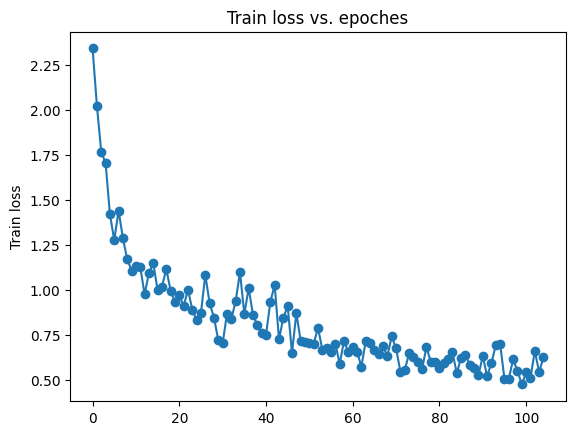

In [ ]:
clsexp.plt_loss()

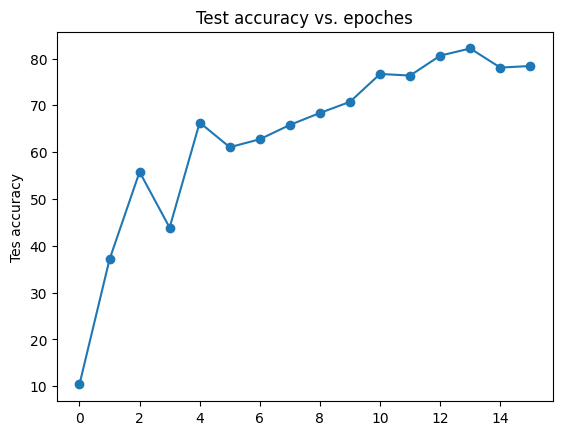

In [ ]:
clsexp.plt_accuracy()

Normalized confusion matrix


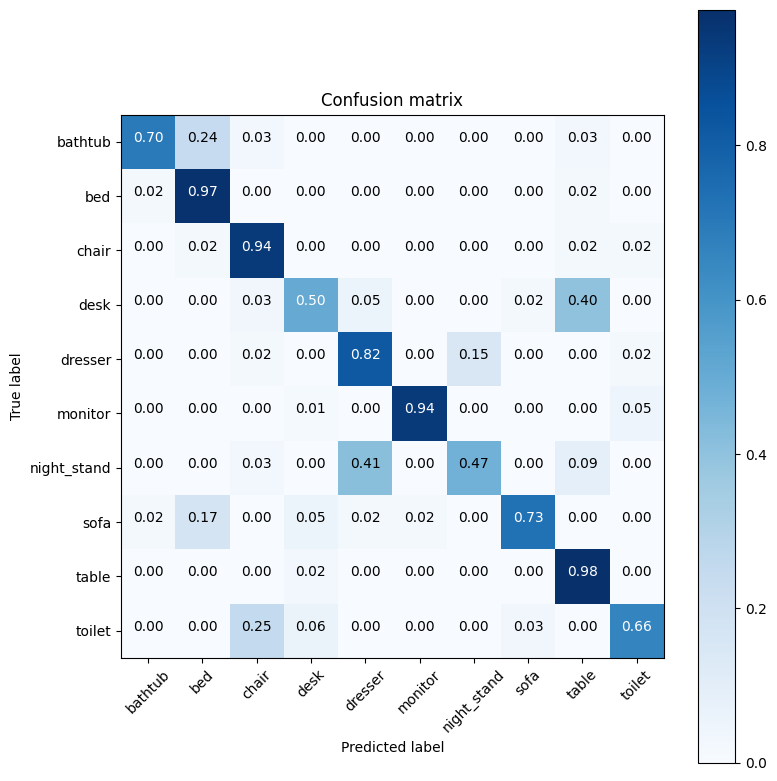

In [ ]:
clsexp.plt_confusion_matrix()